## 2절. RNN으로 영화평 분류하기

In [1]:
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from time import time
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# 하이퍼 파라미터 설정
MY_WORDS = 10000 # 사전 안의 단어 수
MY_LENGTH = 80 # 영화평 길이, 길면 짜름, 짧으면 제로패딩
MY_EMBED = 32 # 임베딩 차원
MY_HIDDEN = 64 # LSTM 차원
MY_SAMPLE = 5 # 임의의 샘플 데이터
MY_EPOCHS = 10 # 반복 학습 수
MY_BATCH = 200 # 매번 가져오는 데이터 수

np.random.seed(111)

In [3]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words=MY_WORDS)

In [4]:
print('학습용 입력 데이터의 모양', X_train.shape)
print('학습용 출력 데이터의 모양', Y_train.shape)
print('평가용 입력 데이터의 모양', X_test.shape)
print('평가용 출력 데이터의 모양', Y_test.shape)

학습용 입력 데이터의 모양 (25000,)
학습용 출력 데이터의 모양 (25000,)
평가용 입력 데이터의 모양 (25000,)
평가용 출력 데이터의 모양 (25000,)


In [5]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
print(len(X_train[0]), len(set(X_train[0])))

218 120


In [7]:
print(Y_train[0])

1


In [8]:
word_to_idx = imdb.get_word_index()

In [9]:
# 가장 많이 사용되는 단어
word_to_idx['the']

1

In [10]:
idx_to_word = dict([(val, key) for (key, val) in word_to_idx.items()])
idx_to_word[1]

'the'

In [11]:
# 인덱스 영화평을 단어 영화평으로 변환
def decoding(review_num):
    decoded = []
    for i in review_num:
        word = idx_to_word[i]
        decoded.append(word)

    return decoded

print(decoding(X_train[0]))

['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'musicians', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', 'have', 'critics', 

In [12]:
idx_to_word = {k+3 : v for k, v in idx_to_word.items()}
idx_to_word[0] = '<PAD>'
idx_to_word[1] = '<START>'
idx_to_word[2] = '<UNK>' # unknown
idx_to_word[3] = '<UNUSED>'
idx_to_word

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

In [13]:
def show_length():
    print('영화평의 길이')
    for i in range(10):
        print('영화평', i, ':', len(X_train[i]))

show_length()

영화평의 길이
영화평 0 : 218
영화평 1 : 189
영화평 2 : 141
영화평 3 : 550
영화평 4 : 147
영화평 5 : 43
영화평 6 : 123
영화평 7 : 562
영화평 8 : 233
영화평 9 : 130


In [14]:
# 2차원 데이터로 변환하기 위해
# 모든 영화평 길이 같게 해야 함.
X_train = pad_sequences(X_train, maxlen=MY_LENGTH, truncating='post', padding='post')
X_test = pad_sequences(X_test, maxlen=MY_LENGTH, truncating='post', padding='post')

In [15]:
show_length()

영화평의 길이
영화평 0 : 80
영화평 1 : 80
영화평 2 : 80
영화평 3 : 80
영화평 4 : 80
영화평 5 : 80
영화평 6 : 80
영화평 7 : 80
영화평 8 : 80
영화평 9 : 80


In [16]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50, 30))
mlp.fit(X_train, Y_train)

In [ ]:
mlp.score(X_test, Y_test)

0.50376

In [ ]:
# RNN 구조
model = Sequential()

model.add(Embedding(input_dim=MY_WORDS, output_dim=MY_EMBED, input_length=MY_LENGTH))
model.add(LSTM(MY_HIDDEN, input_shape=(MY_LENGTH, MY_EMBED)))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='acc')

In [ ]:
begin = time()
model.fit(X_train, Y_train, epochs=MY_EPOCHS, batch_size=MY_BATCH)
end = time()

print(f'training time: {end-begin}')

Epoch 1/10
125/125 [==============================] - 12s 77ms/step - loss: 0.5710 - acc: 0.6810
Epoch 2/10
125/125 [==============================] - 11s 92ms/step - loss: 0.3520 - acc: 0.8510
Epoch 3/10
125/125 [==============================] - 15s 120ms/step - loss: 0.2826 - acc: 0.8872
Epoch 4/10
125/125 [==============================] - 14s 109ms/step - loss: 0.2507 - acc: 0.9058
Epoch 5/10
125/125 [==============================] - 16s 130ms/step - loss: 0.2231 - acc: 0.9182
Epoch 6/10
125/125 [==============================] - 17s 132ms/step - loss: 0.2046 - acc: 0.9250
Epoch 7/10
125/125 [==============================] - 18s 143ms/step - loss: 0.1751 - acc: 0.9379
Epoch 8/10
125/125 [==============================] - 19s 149ms/step - loss: 0.1572 - acc: 0.9456
Epoch 9/10
125/125 [==============================] - 19s 150ms/step - loss: 0.1397 - acc: 0.9508
Epoch 10/10
125/125 [==============================] - 19s 151ms/step - loss: 0.1149 - acc: 0.9622
training time: 159.16

In [ ]:
# 평가용 데이터를 이용한 평가
score = model.evaluate(x=X_test, y=Y_test, verbose=1)
print(f'최종 정확도: {score[1]:.2f}')

782/782 [==============================] - 9s 12ms/step - loss: 0.7760 - acc: 0.7689
최종 정확도: 0.77


In [ ]:
# 테스트 데이터를 이용한 긍정/부정 예측
pred = model.predict(X_test)
print(pred)

[[0.03156692]
 [0.99798155]
 [0.98707974]
 ...
 [0.02434686]
 [0.69162285]
 [0.9899094 ]]


In [ ]:
pred = (pred > 0.5)
print('confusion matrix')
print(confusion_matrix(Y_test, pred))

confusion matrix
[[9786 2714]
 [3063 9437]]


In [ ]:
# 실제 텍스트를 이용한 긍정/부정 판별
text = "My God the actors who potrayed the VIP people cannot\
        act. I cringed everytime they said a line. It felt like they\
        were just reading them. Even the intonation was off. It was\
        like when we were kids and had to read a play in class and we\
        exagerated the intonation. Terrible, just awful."

In [ ]:
input_text = text.lower().split()
print(input_text)

['my', 'god', 'the', 'actors', 'who', 'potrayed', 'the', 'vip', 'people', 'cannot', 'act.', 'i', 'cringed', 'everytime', 'they', 'said', 'a', 'line.', 'it', 'felt', 'like', 'they', 'were', 'just', 'reading', 'them.', 'even', 'the', 'intonation', 'was', 'off.', 'it', 'was', 'like', 'when', 'we', 'were', 'kids', 'and', 'had', 'to', 'read', 'a', 'play', 'in', 'class', 'and', 'we', 'exagerated', 'the', 'intonation.', 'terrible,', 'just', 'awful.']


In [ ]:
word_to_idx = imdb.get_word_index()
word_to_idx = {k:(v+3) for k,v in word_to_idx.items()}
word_to_idx["<PAD>"] = 0
word_to_idx["<START>"] = 1
word_to_idx["<UNK>"] = 2 # unknown
word_to_idx["<UNUSED>"] = 3

In [ ]:
# 단어 숫자로 변환
def encoding(review_text):
    encoded = []
    for word in review_text:
        try:
            idx = word_to_idx[word]
            if idx > 10000:
                encoded.append(3)
            else:
                encoded.append(idx)
        except:
            encoded.append(2)
    
    return encoded

input_encoded = encoding(input_text)
print(input_encoded)

[61, 558, 4, 156, 37, 2, 4, 3, 84, 566, 2, 13, 3, 3, 36, 301, 6, 2, 12, 421, 40, 36, 71, 43, 886, 2, 60, 4, 3, 16, 2, 12, 16, 40, 54, 75, 71, 362, 5, 69, 8, 332, 6, 297, 11, 707, 5, 75, 3, 4, 2, 2, 43, 2]


In [ ]:
input_pad = pad_sequences(np.array(input_encoded)[np.newaxis, :], maxlen=MY_LENGTH, truncating='post', padding='post')
model.predict(input_pad)

array([[0.1096836]], dtype=float32)

## 3절. 로이터 기사 분류하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.datasets import reuters

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [ ]:
MY_SAMPLE = 2947
NUM_CLASS = 46 # 로이터 기사 데이터의 총 카테고리 수
MY_NUM_WORDS = 2000 # 사전 안의 단어의 수
MY_EPOCH = 10 # 학습횟수
MY_BATCH = 64 # 매번 가져와 처리할 데이터의 수
MY_HIDDEN = 512 # 은닉층의 뉴런 수
MY_DROPOUT = 0.5

In [ ]:
labels = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [ ]:
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=MY_NUM_WORDS, test_split=0.3)

2121728/2110848 [==============================] - 0s 0us/step


In [ ]:
def show_shape():
    print('\n== DB SHAPE INFO ==')
    print('X_train shape = ', X_train.shape)
    print('X_test shape = ', X_test.shape)
    print('Y_train shape = ', Y_train.shape)
    print('Y_test shape = ', Y_test.shape)
    
show_shape() 


== DB SHAPE INFO ==
X_train shape =  (7859,)
X_test shape =  (3369,)
Y_train shape =  (7859,)
Y_test shape =  (3369,)


In [ ]:
# 레이블 별 데이터 개수
unique, counts = np.unique(Y_train, return_counts=True)
for i in range(len(unique)):
    print(unique[i], labels[i], '=', counts[i])

0 cocoa = 50
1 grain = 378
2 veg-oil = 66
3 earn = 2769
4 acq = 1701
5 wheat = 14
6 copper = 39
7 housing = 15
8 money-supply = 126
9 coffee = 93
10 sugar = 114
11 trade = 337
12 reserves = 40
13 ship = 149
14 cotton = 18
15 carcass = 19
16 crude = 387
17 nat-gas = 33
18 cpi = 59
19 money-fx = 475
20 interest = 238
21 gnp = 91
22 meal-feed = 10
23 alum = 36
24 oilseed = 56
25 gold = 77
26 tin = 18
27 strategic-metal = 13
28 livestock = 43
29 retail = 19
30 ipi = 38
31 iron-steel = 34
32 rubber = 30
33 heat = 9
34 jobs = 43
35 lei = 10
36 bop = 46
37 zinc = 17
38 orange = 16
39 pet-chem = 20
40 dlr = 32
41 gas = 28
42 silver = 10
43 wpi = 19
44 hog = 10
45 lead = 14


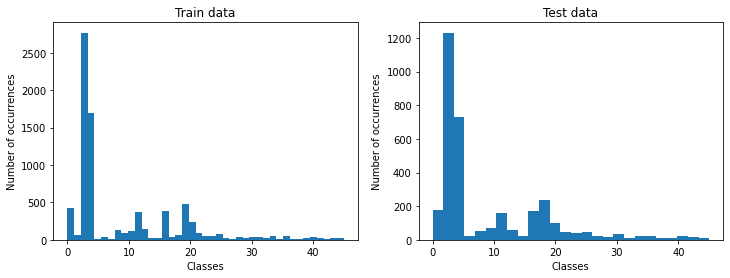

In [ ]:
# 학습용 데이터와 평가용 데이터의 클래스별 개수 시각화
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(Y_train, bins='auto')
plt.xlabel('Classes')
plt.ylabel('Number of occurrences')
plt.title('Train data')

plt.subplot(122)
plt.hist(Y_test, bins='auto')
plt.xlabel('Classes')
plt.ylabel('Number of occurrences')
plt.title('Test data')

plt.show()

In [ ]:
# 샘플기사 (2947번) 카테고리와 단어의 수, 실제 데이터 출력
print('article #', MY_SAMPLE)
print('category', Y_train[MY_SAMPLE], labels[Y_train[MY_SAMPLE]])
print('number of words', len(X_train[MY_SAMPLE]))
print(X_train[MY_SAMPLE]) 

article # 2947
category 4 acq
number of words 61
[1, 2, 1229, 81, 8, 16, 515, 25, 270, 5, 4, 2, 1229, 111, 267, 7, 73, 2, 2, 7, 108, 13, 80, 1448, 28, 365, 12, 11, 15, 1986, 2, 69, 158, 18, 1296, 1275, 7, 2, 1627, 2, 2, 4, 393, 374, 1229, 323, 5, 2, 1229, 7, 2, 9, 25, 2, 473, 936, 4, 49, 8, 17, 12]


In [ ]:
# 단어-인덱스 정보 불러옴
word_to_idx = reuters.get_word_index()

print(f'딕셔너리에 {len(word_to_idx) + 1}개 단어 존재함.')
print(f'단어 the 의 인덱스: {word_to_idx["the"]}')

565248/550378 [==============================] - 0s 0us/step
딕셔너리에 30980개 단어 존재함.
단어 the 의 인덱스: 1


In [ ]:
# 단어-인덱스 => 인덱스-단어 딕셔너리 변환
idx_to_word = dict([(val, key) for (key, val) in idx_to_word.items()])

In [ ]:
# 인덱스를 문자로 디코딩
def decoding():
    decoded = []
    for i in X_train[MY_SAMPLE]:
        word = idx_to_word.get(i-3, '???')
        decoded.append(word)

    return decoded

print(decoding())

['???', '???', 'south', 'bad', 'and', 'i', 'genre', 'film', 'looking', '<UNK>', '<START>', '???', 'south', 'films', 'believe', 'the', 'can', '???', '???', 'the', 'characters', 'br', 'been', 'bed', 'you', 'kids', 'is', 'to', 'it', 'm', '???', 'really', 'thing', 'that', 'beautifully', 'army', 'the', '???', 'professional', '???', '???', '<START>', 'episode', 'truly', 'south', 'half', '<UNK>', '???', 'south', 'the', '???', 'a', 'film', '???', '4', 'deep', '<START>', 'out', 'and', 'this', 'is']


In [ ]:
tok = Tokenizer(num_words=MY_NUM_WORDS)
X_train_tok = tok.sequences_to_matrix(X_train, mode='count')
X_test_tok = tok.sequences_to_matrix(X_test, mode='count')

In [ ]:
sample = X_train_tok[MY_SAMPLE]
# print(*sample, sep=' ')
print('array size: ', len(sample))
print('sum: ', np.sum(sample))

array size:  2000
sum:  61.0


In [ ]:
# 단순 은닉층 갖는 DNN
model = Sequential()

model.add(Dense(MY_HIDDEN, input_shape=(MY_NUM_WORDS,)))
model.add(Activation("relu"))
model.add(Dropout(MY_DROPOUT))

model.add(Dense(NUM_CLASS))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               1024512   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 46)                23598     
                                                                 
 activation_1 (Activation)   (None, 46)                0         
                                                                 
Total params: 1,048,110
Trainable params: 1,048,110
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.fit(X_train_tok, Y_train, validation_data=(X_test_tok, Y_test), epochs=MY_EPOCH, batch_size=MY_BATCH, verbose=1)

Epoch 1/10
123/123 [==============================] - 2s 9ms/step - loss: 1.6425 - accuracy: 0.6696 - val_loss: 1.0820 - val_accuracy: 0.7744
Epoch 2/10
123/123 [==============================] - 1s 8ms/step - loss: 0.8293 - accuracy: 0.8198 - val_loss: 0.9364 - val_accuracy: 0.7925
Epoch 3/10
123/123 [==============================] - 1s 7ms/step - loss: 0.5739 - accuracy: 0.8708 - val_loss: 0.8772 - val_accuracy: 0.8145
Epoch 4/10
123/123 [==============================] - 1s 7ms/step - loss: 0.4301 - accuracy: 0.8987 - val_loss: 0.8780 - val_accuracy: 0.8100
Epoch 5/10
123/123 [==============================] - 1s 7ms/step - loss: 0.3359 - accuracy: 0.9206 - val_loss: 0.8992 - val_accuracy: 0.8175
Epoch 6/10
123/123 [==============================] - 1s 7ms/step - loss: 0.2854 - accuracy: 0.9317 - val_loss: 0.9105 - val_accuracy: 0.8127
Epoch 7/10
123/123 [==============================] - 1s 7ms/step - loss: 0.2397 - accuracy: 0.9406 - val_loss: 0.9393 - val_accuracy: 0.8100
Epoch 

In [ ]:
sample = X_train_tok[MY_SAMPLE]
sample = sample.reshape(1, sample.shape[0])

pred = model.predict(sample, verbose=0)
guess = np.argmax(pred)
answer = Y_train[MY_SAMPLE]

print("샘플 기사의 예측값:", guess, labels[guess])
print("실제 정답:", answer, labels[answer])

샘플 기사의 예측값: 4 acq
실제 정답: 4 acq


In [ ]:
model.evaluate(X_test_tok, Y_test)

106/106 [==============================] - 0s 3ms/step - loss: 0.9862 - accuracy: 0.8121


[0.986157238483429, 0.812110424041748]

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(MY_HIDDEN,), solver="adam", activation="relu", max_iter=10)
mlp.fit(X_train_tok, Y_train)

C:\Users\ameli\anaconda3\envs\saltlux_deep_lecture\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(512,), max_iter=10)

In [ ]:
mlp.predict(sample)

array([4], dtype=int64)

In [ ]:
mlp.score(X_test_tok, Y_test)

0.796675571386168

## 4절. 영-한 번역기

In [1]:
import numpy as np
import pandas as pd

from numpy.random import randint
from time import time
from keras.layers import Input, LSTM, Dense
from keras.models import Model

In [2]:
MY_HIDDEN = 128 # 은닉층의 뉴런의 수
MY_EPOCHS = 500 # 학습횟수 하이퍼 파라미터

In [3]:
# 영문자와 한글 문자를 연결한 알파벳/문자 데이터 생성
arr1 = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz']
arr2 = pd.read_csv('datasets/korean.csv', header=None)
arr2 = arr2[0].values.tolist()
num_to_char = arr1 + arr2
len(num_to_char)

171

In [4]:
# 각 알파벳/문자에 엔덱스 부여
char_to_num = {n : i for i, n in enumerate(num_to_char)}
n_input = len(char_to_num)

print('글자 사전\n', char_to_num)
print(f'총 글자 수: {len(char_to_num)}')
print(f'영어 글자 수: {len(arr1)}')
print(f'한글 글자 수: {len(arr2)}')

글자 사전
 {'S': 0, 'E': 1, 'P': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '가': 29, '각': 30, '간': 31, '감': 32, '개': 33, '거': 34, '것': 35, '게': 36, '계': 37, '고': 38, '관': 39, '광': 40, '구': 41, '굴': 42, '규': 43, '그': 44, '금': 45, '기': 46, '깊': 47, '나': 48, '날': 49, '남': 50, '내': 51, '넓': 52, '녀': 53, '노': 54, '놀': 55, '농': 56, '높': 57, '뉴': 58, '늦': 59, '다': 60, '단': 61, '도': 62, '동': 63, '들': 64, '람': 65, '랑': 66, '래': 67, '램': 68, '류': 69, '름': 70, '릎': 71, '리': 72, '많': 73, '망': 74, '매': 75, '머': 76, '먼': 77, '멍': 78, '메': 79, '명': 80, '모': 81, '목': 82, '무': 83, '물': 84, '미': 85, '바': 86, '반': 87, '방': 88, '번': 89, '복': 90, '부': 91, '분': 92, '붕': 93, '비': 94, '뿌': 95, '사': 96, '상': 97, '색': 98, '생': 99, '서': 100, '선': 101, '소': 102, '손': 103, '수': 104, '쉽': 105, '스': 106, '시': 107, '식': 108, '실': 109, '싸

In [5]:
raw = pd.read_csv('datasets/translate.csv', header=None)
eng_kor = raw.values.tolist()

print('사전 내용\n', eng_kor)
print('총 단어 수: ', len(eng_kor))

사전 내용
 [['cold', '감기'], ['come', '오다'], ['cook', '요리'], ['copy', '복사'], ['cost', '비용'], ['date', '날짜'], ['deal', '거래'], ['deep', '깊은'], ['desk', '책상'], ['down', '아래'], ['dust', '먼지'], ['duty', '의무'], ['each', '각각'], ['east', '동쪽'], ['easy', '쉽다'], ['exit', '탈출'], ['face', '얼굴'], ['fact', '사실'], ['fall', '가을'], ['farm', '농장'], ['feet', '다리'], ['find', '찾다'], ['fine', '좋다'], ['fish', '생선'], ['flow', '흐름'], ['fund', '기금'], ['gain', '수익'], ['game', '놀이'], ['gift', '선물'], ['girl', '소녀'], ['give', '주다'], ['goal', '목적'], ['gray', '회색'], ['hair', '머리'], ['harm', '피해'], ['hell', '지옥'], ['help', '도움'], ['high', '높은'], ['hole', '구멍'], ['hope', '소망'], ['hour', '시각'], ['join', '합류'], ['kiss', '키스'], ['knee', '무릎'], ['lady', '부인'], ['late', '늦은'], ['left', '왼쪽'], ['life', '생명'], ['loss', '손해'], ['love', '사랑'], ['luck', '행운'], ['mail', '우편'], ['male', '남자'], ['many', '많은'], ['meal', '식사'], ['meat', '고기'], ['menu', '메뉴'], ['milk', '우유'], ['name', '이름'], ['news', '뉴스'], ['next', '다음'], ['once', '한번'], 

In [6]:
# 영어와 한글 인코딩 입력, 디코딩 입력, 디코딩 출력으로 변환
def encode(eng_kor):
    enc_in = []
    dec_in = []
    rnn_out = []

    for seq in eng_kor:
        eng = [char_to_num[c] for c in seq[0]]
        enc_in.append(np.eye(n_input)[eng])

        kor = [char_to_num[c] for c in ('S'+seq[1])]
        dec_in.append(np.eye(n_input)[kor])

        target = [char_to_num[c] for c in (seq[1]+'E')]
        rnn_out.append(target)

    enc_in = np.array(enc_in)
    dec_in = np.array(dec_in)
    rnn_out = np.array(rnn_out)

    # 3차원 구조로 변환
    rnn_out = np.expand_dims(rnn_out, axis=2)

    return enc_in, dec_in, rnn_out

In [7]:
sample = [['word', '단어']]
enc_in, dec_in, rnn_out = encode(sample)

In [8]:
# 인코더 입력 값 샘플 출력
print('\n인코더 입력 값 샘플')
print('데이터 모양:', enc_in.shape)
print(enc_in)

for i in range(4):
    char = np.argmax(enc_in[0, i])
    print(num_to_char[char])


인코더 입력 값 샘플
데이터 모양: (1, 4, 171)
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [9]:
# 디코더 입력 값 샘플 출력
print('\n디코더 입력 값 샘플')
print('데이터 모양:', dec_in.shape)
print(dec_in)

for i in range(3):
    char = np.argmax(dec_in[0, i])
    print(num_to_char[char])


디코더 입력 값 샘플
데이터 모양: (1, 3, 171)
[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [10]:
# RNN 출력 값 샘플 출력
print('\nRNN 출력 값 샘플')
print('데이터 모양:', rnn_out.shape)
print(rnn_out)

for i in range(3):
    num = rnn_out[0, i, 0]
    print(num_to_char[num])


RNN 출력 값 샘플
데이터 모양: (1, 3, 1)
[[[ 61]
  [114]
  [  1]]]
단
어
E


In [11]:
X_enc, X_dec, Y_rnn = encode(eng_kor)

print('인코더 입력값 모양', X_enc.shape)
print('디코더 입력값 모양', X_dec.shape)
print('출력값 모양', Y_rnn.shape)

인코더 입력값 모양 (110, 4, 171)
디코더 입력값 모양 (110, 3, 171)
출력값 모양 (110, 3, 1)


In [12]:
# LSTM을 이용한 인공신경망 모형 정의
enc_IN = Input(shape=(4, n_input))
_, state_h, state_c = LSTM(units=MY_HIDDEN, return_state=True)(enc_IN)

link = [state_h, state_c]

dec_IN = Input(shape=(3, n_input))
dec_Y1 = LSTM(units=MY_HIDDEN, return_sequences=True)(dec_IN, initial_state=link)
dec_Y2 = Dense(units=n_input, activation='softmax')(dec_Y1)

model = Model(inputs=[enc_IN, dec_IN], outputs=dec_Y2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 171)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3, 171)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        153600      ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [14]:
begin = time()
model.fit([X_enc, X_dec], Y_rnn, epochs=MY_EPOCHS)
end = time()
print(f'training time: {(end-begin): .2f}초')

Epoch 1/500
4/4 [==============================] - 3s 6ms/step - loss: 5.1296
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 5.0867
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 5.0297
Epoch 4/500
4/4 [==============================] - 0s 7ms/step - loss: 4.9334
Epoch 5/500
4/4 [==============================] - 0s 6ms/step - loss: 4.7456
Epoch 6/500
4/4 [==============================] - 0s 6ms/step - loss: 4.3477
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 3.6749
Epoch 8/500
4/4 [==============================] - 0s 13ms/step - loss: 3.5566
Epoch 9/500
4/4 [==============================] - 0s 10ms/step - loss: 3.5758
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 3.4000
Epoch 11/500
4/4 [==============================] - 0s 6ms/step - loss: 3.3835
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 3.3816
Epoch 13/500
4/4 [==============================] - 0s 6ms/

In [15]:
pick = randint(0, len(eng_kor), 5)
choose = [eng_kor[i] for i in pick]

In [16]:
try_this = [['love', 'PP'], ['olve', 'PP'], ['lvoe', 'PP'], ['loev', 'PP'], ['eovl', 'PP']]
new_data = choose + try_this
new_data

[['rest', '휴식'],
 ['male', '남자'],
 ['when', '언제'],
 ['menu', '메뉴'],
 ['wife', '아내'],
 ['love', 'PP'],
 ['olve', 'PP'],
 ['lvoe', 'PP'],
 ['loev', 'PP'],
 ['eovl', 'PP']]

In [17]:
enc_in, dec_in, _ = encode(new_data)
pred = model.predict([enc_in, dec_in])
print(f'예측 결과의 모양: {pred.shape}')

예측 결과의 모양: (10, 3, 171)


In [18]:
# 예측 결과에서 한글 추출
for i in range(len(new_data)):
    eng = new_data[i][0]
    word = np.argmax(pred[i], axis=1)
    kor = ''
    for j in range(2):
        kor = kor + num_to_char[word[j]]
    
    print(eng, '=>', kor)

rest => 휴식
male => 남자
when => 언제
menu => 메뉴
wife => 아내
love => 사랑
olve => 사E
lvoe => 사사
loev => 사E
eovl => 도리
